In [105]:
import numpy as np 
from scipy import signal
import sys 
import os
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath("/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering"))
from Code.utilities import DAS

In [106]:
        
def crossCorrOneBit(virtualSrcTrace, allOtherReceiversTraces, nLagSamples, version = 'C'):
    '''version = C or python where that determines which language is used for correlation calculation'''
    numberChannels = allOtherReceiversTraces.shape[0]
    xCorr = np.empty((numberChannels,1+2*nLagSamples),dtype=np.int32)
    
        #number of samples 
    nt = allOtherReceiversTraces.shape[1]
        
    sumWidth = nt-2*nLagSamples
	# do +- 1 bit thresholding
    vsOneBit = np.ones_like(virtualSrcTrace)
	# ****do threhsolding***
    recsOneBit = np.ones_like(allOtherReceiversTraces)
    print(vsOneBit)
    print(recsOneBit)
	# ****do thresholding
    for i in range(-1*nLagSamples,nLagSamples+1):
        startSample = i + nLagSamples
        endSample = startSample + sumWidth
        #do the actual integration 
        # source * rec
        tempArray = vsOneBit[startSample:endSample]*recsOneBit[:,nLagSamples:nLagSamples+sumWidth]
        xCorr[:,i+nLagSamples] = np.sum(tempArray,axis=1)
    return xCorr

In [107]:
def bpfilter(data, dt, bp_low, bp_high):
    '''
    Butterworth filter
    '''
    sos = signal.butter(6, [bp_low, bp_high], btype='bandpass', fs=1/dt, output='sos')
    return signal.sosfiltfilt(sos, data, axis=-1)

def DAS_preprocessing(data, dt, fl, fh):
    """this is important otherwise the plot doesn't look right 

    Args:
        data (_type_): _description_
        dt (_type_): _description_
        fl (_type_): _description_
        fh (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = signal.detrend(data, axis=1)
    data = data - np.median(data, axis=0)
    data = bpfilter(data, dt, fl, fh)
    print(dt)
    return data

In [108]:
t = np.linspace(0, 5, 100)
source = np.sin(t)
recievers = [np.cos(t) if i ==1 else np.sin(t) for i in range(2)]
recievers = np.stack(recievers, axis=1)
correlation = np.correlate(source, recievers[:,0])
one_bit_correlation = DAS.one_bit_cross_cor(source, recievers.T, 6)
print("correlation is", correlation)
print("one bit corss correlation is", one_bit_correlation)
correlation_signal = signal.correlate(source, recievers[:, 0])
print(correlation_signal.shape)


correlation is [52.65038234]
one bit corss correlation is [81.  7.]
(199,)


In [109]:

DAS_Stanford = np.load("../Data/september10data/20160910_00:00:54.npy")
DAS_Stanford = DAS_preprocessing(DAS_Stanford, .02, fl=0.2, fh = 24)

0.02


In [110]:
n_channels = 286
n_time_lags = 200
source_channel = 140

time_lags = np.linspace(0, n_time_lags,n_time_lags)
cross_cor_DAS = np.zeros((n_channels, n_time_lags))
#vectorize ? 
for i in range(n_time_lags): 
    cor = DAS.one_bit_cross_cor(DAS_Stanford[source_channel, :], DAS_Stanford[:n_channels,:], i)
    cross_cor_DAS[:, i] = cor / np.linalg.norm(cor, ord=1)


0.055474603726414044


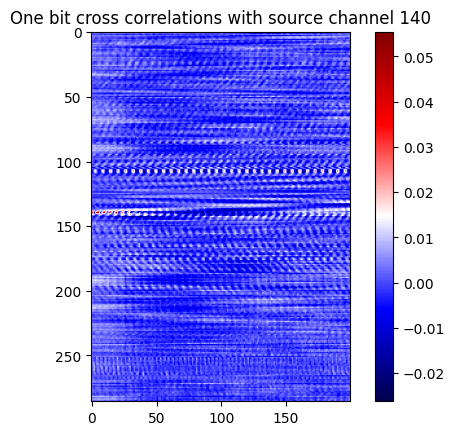

In [111]:
print(np.max(cross_cor_DAS))
plt.imshow(cross_cor_DAS , cmap="seismic")
plt.title(f'One bit cross correlations with source channel {source_channel}')
plt.colorbar()